<a href="https://www.kaggle.com/code/lumarian/league-of-legends-10-min-prediction-model?scriptVersionId=159388053" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting Win Probability at 10 Minutes in a League of Legends Game
I was always curious about how win probability is calculated live on the overlay during pro matches, so I wanted to try it out for myself. I'm using data with a sample size of around 10k ranked games in high Diamond to Masters elo, provided by Kaggle user  Yi Lan Ma.

The data is pretty old in terms of the game, as it was posted 4 years ago. I'm curious if the meta has changed so much since then that a model trained on this data would result in a lot of error if tested on data from current games.

This is also my first time building a decision tree, so it's probably not that good.

In [1]:
import numpy as np
import pandas as pd
import math, statistics, matplotlib as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import tree



/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv


In [2]:
# reading in dataset
lolpath="/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv"
loldat = pd.read_csv(lolpath)

## Selecting Features
There are lot of features in the raw data. A lot of these features are essentially the same thing, but before I get rid of them, I want to see the correlation for myself, using a correlation heat map.

In [3]:
y = loldat.blueGoldDiff
lol_features = ['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin']
X = loldat[lol_features]

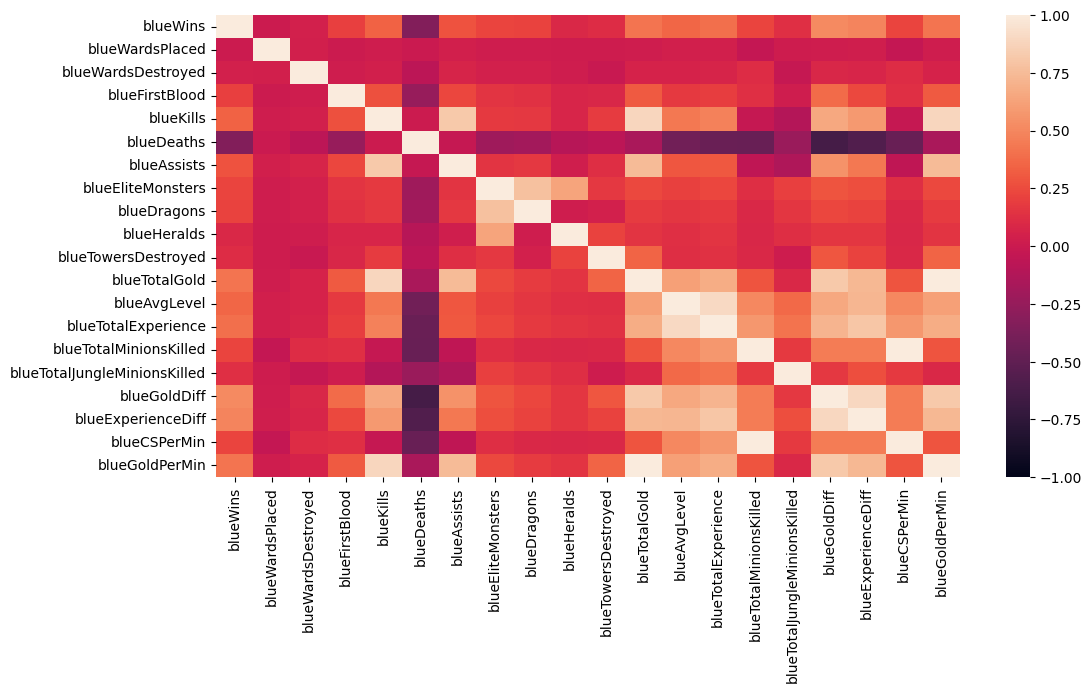

In [4]:
# Correlation Heat Map
import seaborn as sns
import matplotlib.pyplot as plt

lolfeat = loldat[['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin']]
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(lolfeat.corr(), vmin=-1, vmax=1)

As expected, a lot of the variables have high correlation. I didn't even notice they included CS and minions killed when they are almost the same thing. We can improve the model by getting rid of redundant features. 

In [5]:
lol_features = ['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters','blueTowersDestroyed','blueAvgLevel',
        'blueTotalExperience','blueGoldDiff']
X = loldat[lol_features]

Since League is a competitive game, the stats by themselves don't off much valuable insight towards win probability. I'm more interested stat relative to the enemy team, so I'll make some new features based on the difference of the stats I'm interested in.

In [6]:
def get_diff(blue, red):
    #diff = loldat.columns.get_loc(blue) - loldat.columns.get_loc(red)
    diff = blue-red
    return diff

# getting the differences between the stats
lol_blue = ['blueWardsPlaced', 'blueKills', 'blueDeaths', 'blueAssists','blueEliteMonsters','blueTowersDestroyed','blueAvgLevel']
difflist = []
for blue in lol_blue:
    stat = blue[4:]
    red = "red"+stat
    diff = stat+"diff"
    difflist.append(diff)
    loldat[diff] = loldat.apply(lambda x: get_diff(blue = x[blue], red = x[red]),  axis=1)

loldiffs = loldat[difflist]
loldiffs.insert(1, "blueWins", loldat.blueWins, True)
loldiffs.insert(2, "blueGoldDiff", loldat.blueGoldDiff, True)

print(difflist)

['WardsPlaceddiff', 'Killsdiff', 'Deathsdiff', 'Assistsdiff', 'EliteMonstersdiff', 'TowersDestroyeddiff', 'AvgLeveldiff']


## Fitting the Model
I'm using a DecisionTreeClassifier and truncating it to obtain a probability, rather than a binary prediction. I think it's more interesting to observe win probability instead of win/lose because League is such an unpredictable game that your chances of winning is never 100%, no matter how ahead you are.

In [7]:
lol_features = ['blueGoldDiff', 'WardsPlaceddiff', 'Killsdiff', 'Assistsdiff', 'EliteMonstersdiff', 'TowersDestroyeddiff', 'AvgLeveldiff']
X = loldiffs[lol_features]
y = loldiffs.blueWins
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

# Truncating the tree because I want to see win probability, not a binary result
lol_model2 = DecisionTreeClassifier(max_depth=5)
lol_model2.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=5)

Here's a visualization of our tree.

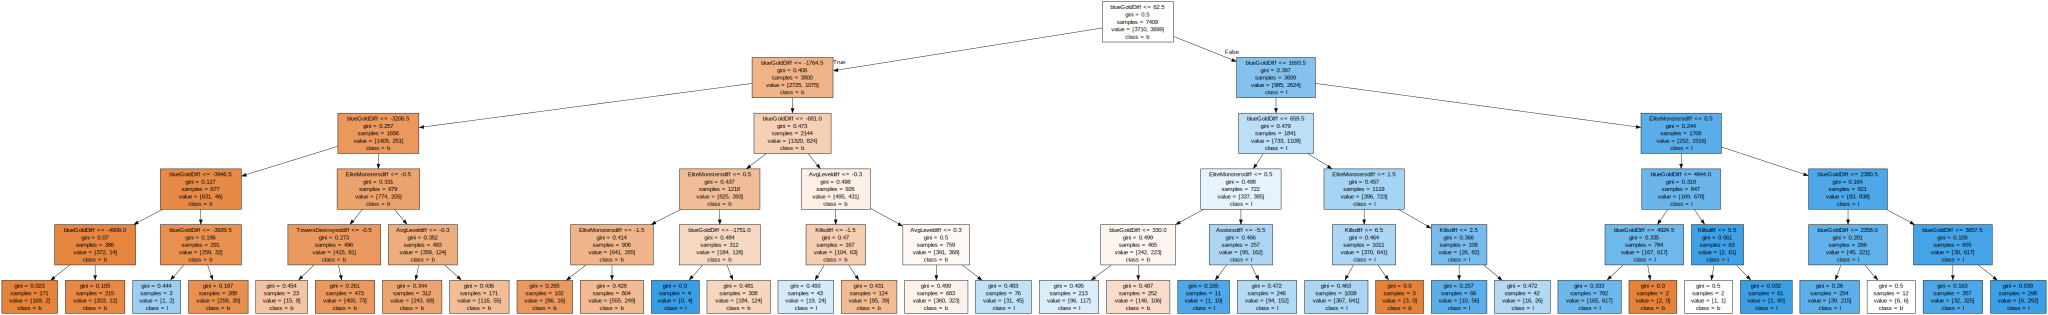

In [8]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(lol_model2, out_file=None, 
                                feature_names=lol_features,  
                                class_names='blueWins',
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph


In [9]:
print(Xtest.head())
print(lol_model2.predict_proba(Xtest.head()))


      blueGoldDiff  WardsPlaceddiff  Killsdiff  Assistsdiff  \
4928          4545             -1.0        9.0          8.0   
2754          2789             -2.0        5.0          5.0   
8662          3360              0.0        6.0          8.0   
5720            17             12.0        1.0          2.0   
5435           951             -2.0        1.0          2.0   

      EliteMonstersdiff  TowersDestroyeddiff  AvgLeveldiff  
4928                0.0                  0.0           1.2  
2754                1.0                  0.0           1.0  
8662                1.0                  0.0           0.4  
5720                0.0                  0.0          -0.4  
5435               -2.0                  0.0           0.2  
[[0.21099744 0.78900256]
 [0.08963585 0.91036415]
 [0.08963585 0.91036415]
 [0.68548387 0.31451613]
 [0.3640873  0.6359127 ]]


blueWins=0 means a loss for blue team, and blueWins=1 means a win. So the win probability is the second value in the probabilities returned ([loss, win]). So far, just looking at the results, it seems pretty reasonable. Having a gold advantage and kill advantage definitely seems to make a big difference. 

In [10]:
# I'll test it on an actual game. WBG vs. T1 game 1 at Worlds 2023 finals
# WBG as blue team
g1 = {"blueGoldDiff":[-500], 'WardsPlaceddiff': [-2],'Killsdiff': [1], 'Assistsdiff': [-1],'EliteMonstersdiff':-1, 'TowersDestroyeddiff': 0, 'AvgLeveldiff': -0.2}
g1_df = pd.DataFrame(g1)
print(g1_df)
print(lol_model2.predict_proba(g1_df))


   blueGoldDiff  WardsPlaceddiff  Killsdiff  Assistsdiff  EliteMonstersdiff  \
0          -500               -2          1           -1                 -1   

   TowersDestroyeddiff  AvgLeveldiff  
0                    0          -0.2  
[[0.52708638 0.47291362]]


## Conclusion

I'll test it out on an actual game. I took the data from WBG vs. T1 game 1 at Worlds 2023 Finals, with WBG as the blue team. I realized it's kind of hard to determine the number of wards placed, so I used Vision Score instead, which probably skewed the result a bit. If I can figure out the Vision Score formula that Riot uses, I can calculate the difference and use that as a feature instead. This seems reasonable, since WBG was behind a little but they still had a decent chance to win. However, they ended up losing the game. This is probably attributed to the model being trained on Diamond-Masters elo, where the early kills happen more often and have greater impact compared to pro play. I'll continue to test and improve my model, but that's all for now. 